In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties import unumpy
import uncertainties

In [4]:
kb = 1.380649e-23
hbar = 1.054571e-34
T = 293

In [5]:
def modelSimplified(f,D,gamma,f_0):
    
    gamma = abs(gamma)
    D = abs(D)
    numerator = D*gamma
    w = f*2*np.pi
    w_0 = f_0*2*np.pi
    denominator = (w**2-w_0**2)**2 +(gamma*w)**2
    
    return  numerator/denominator

def psdEvalWithSTD(pathFolders,label, windows = 10, channel = 'ch1',
                  welchMethod = 1, verbose = True, delete = False, factor=1,
                  padding = 0, padSize=None, nfft = None):
    
    data = {"time": [],
            "traces": []}
    for file in os.listdir(pathFolders):
        if file.endswith('.pkl'):
            filePath = os.path.join(pathFolders,file)
            df_signal = pd.read_pickle(filePath)
            data['time'].append(df_signal.t.values)
            data['traces'].append(df_signal[channel].values)
    dt = np.diff(data['time'][0])[0]
    f = 1/dt
    nperseg = int(len(data["traces"][0])/windows)
    if padding:
        if not padSize:
            padSize = data["traces"][0].shape[0]
        for i in range(len(data["traces"])):
            data["traces"][i] = np.pad(data["traces"][i], padSize,
            'constant')[padSize:]
    nperseg = int(len(data["traces"][0])/windows)
    powers = []
    if welchMethod == 1: #if welch method is ON
        freq, power = signal.welch(data["traces"][0]*factor, f, window = 'hamming', nperseg = nperseg, nfft = nfft)
        powers.append(power)
        for i in range(1,len(data["traces"])):
            freq, power = signal.welch(data["traces"][i]*factor, f, window = 'hamming', nperseg = nperseg, nfft = nfft)
            powers.append(power/np.sqrt(2*np.pi))
    powers = np.array(powers)
    return freq, powers

In [6]:

def compute_zero_point(omega, radius=143e-9/2, rho=2200):
    m = rho * 4 * np.pi * np.power(radius, 3) / 3
    return np.sqrt(hbar / (2 * omega * m))


In [7]:
def filter_psd(freq, powers, left_filter, right_filter, condition):
    filt_power = []
    idxLeft = np.where(freq <= left_filter)[0][-1]
    idxRight = np.where(freq >= right_filter)[0][0]
    for power in powers:
        crop_power = power[idxLeft:idxRight]
        if crop_power.max() < condition:
            filt_power.append(power)
    return np.array(filt_power)

In [23]:
def compute_fit(rootFolder, windows, channel, leftCrop, rightCrop, left_filter, right_filter, condition,
                T = ufloat(293.15, 1), diameter = ufloat(143e-9, 0.01e-6),
                rho = 2200, kb = 1.380649e-23, nfft = None):    
    volume = (4/3)*np.pi*(diameter/2)**3
    mass = volume*rho
    
    freq, powers = psdEvalWithSTD(rootFolder, '', windows = windows, channel = channel,
                                         verbose = False, nfft = nfft)
    powers = filter_psd(freq, powers, left_filter, right_filter, condition)
    power = unumpy.uarray(np.mean(powers, axis = 0),
                   np.std(powers, axis = 0))

    idxLeft = np.where(freq <= leftCrop)[0][-1]
    idxRight = np.where(freq >= rightCrop)[0][0]
    trfreq = freq[idxLeft:idxRight]
    trPSD = power[idxLeft:idxRight]

    delta = 15*max(unumpy.std_devs(trPSD))
    ref = min(unumpy.nominal_values(trPSD))
    Sm = delta + ref
    idxHalfLeft = np.where(unumpy.nominal_values(trPSD) >= ref + delta/250)[0][0]
    idxHalfRight = np.where(unumpy.nominal_values(trPSD) >= ref + delta/250)[0][-1]
    trfreq = trfreq[idxHalfLeft:idxHalfRight]
    trPSD = trPSD [idxHalfLeft:idxHalfRight]
    
    f_0_hint = (trfreq[0] + trfreq[-1])/2
    gamma_hint = trfreq[-1] - trfreq[0]
    w_0_hint = f_0_hint*2*np.pi
    D_hint = Sm*gamma_hint*w_0_hint**2
    hint = [D_hint,gamma_hint,f_0_hint]
    ans,cov = curve_fit(modelSimplified,trfreq,unumpy.nominal_values(trPSD),
                        p0 = hint, sigma= unumpy.std_devs(trPSD), absolute_sigma=True, maxfev = 10000)

    D = ufloat(abs(ans[0]) , sqrt(cov[0,0]))
    detectorCalibration = sqrt(D*mass/(4*kb*T))





    ans,cov = curve_fit(modelSimplified,trfreq,unumpy.nominal_values(trPSD),
                        p0 = hint, sigma= unumpy.std_devs(trPSD), absolute_sigma=True, maxfev = 10000)
    return freq, power, ans

In [9]:

def compute_temperature(detectorCalibration, ans):
    full_freq = np.linspace(0,2e5,int(5e4))
    factor = 2*np.power(compute_zero_point(2*np.pi*ans[2])*detectorCalibration,2)
    y = modelSimplified(full_freq,*ans)
    n_ph = -1/2 + 2*np.pi*np.diff(full_freq)[0]*\
    y.sum()/factor
    Te = n_ph*hbar*ans[2]/kb
    return Te

In [19]:
def get_temperature_axis(path, calibration, windows, 
                         channel, leftCrop, rightCrop, 
                         left_filter, right_filter, condition,
                         nfft=None):
    freq, power, ans = compute_fit(path, windows, channel,
                                    leftCrop, rightCrop, 
                                    left_filter, right_filter, condition,
                                    nfft=nfft)
    return freq, power, ans

In [20]:
detec_x = uncertainties.ufloat(686554.2,72247.0)
detec_y = uncertainties.ufloat(707836.4,74542.2) 
detec_z = uncertainties.ufloat(106836.8,11311.7)

#high_p = 0.86 mbar
#middle = 0.054 mbar
#low = 0.000063

In [162]:
""
root_folder = "/home/terahertz-qa/data/measurements-dissertation/all-electrical/second_meas/"
pressure_folder = "1.2" #esta é a ultima pasta processada
#0.175
#0.16
windows_D = 4 # should be optimized for fitting in detectorProcess
temps, std_temps = [], []
     


leftCrop = {'x': 94.0e3, 'y': 97e3, 'z': 22e3}
rightCrop = {'x':97.5e3, 'y': 100e3, 'z': 39e3}

left_filter = {'x': 90e3, 'y': 90e3, 'z': 20e3}
right_filter = {'x':110e3, 'y': 110e3, 'z': 60e3}
nfft=None
path = '{}/{}'.format(root_folder, pressure_folder)
freq_x, power_x, ans_x = get_temperature_axis(path, detec_x, windows_D, 'ch1', leftCrop['x'], rightCrop['x'], left_filter['x'], right_filter['x'], 1e-4, nfft)
freq_y, power_y, ans_y = get_temperature_axis(path, detec_y, windows_D, 'ch2', leftCrop['y'], rightCrop['y'], left_filter['y'], right_filter['y'], 1e-5, nfft)
freq_z, power_z, ans_z = get_temperature_axis(path, detec_z, windows_D, 'ch2', leftCrop['z'], rightCrop['z'], left_filter['z'], right_filter['z'], 2e-7, nfft)
#t_z = get_temperature_axis(path, detec_z, windows_D, 'ch2', leftCrop['z'], rightCrop['z'], left_filter['z'], right_filter['z'], 1e-7) 
# ESTE VALOR ACIMA FOI USADO PARA PRATICAMENTE TODAS MEDICOES DE Z ENTRE 1E-1 E 1E-3


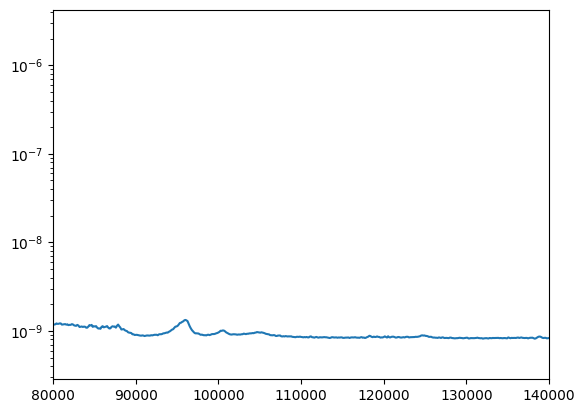

In [153]:
plt.plot(freq_x, unumpy.nominal_values(power_x))
plt.yscale('log')
plt.xlim([80e3,140e3])
plt.show()

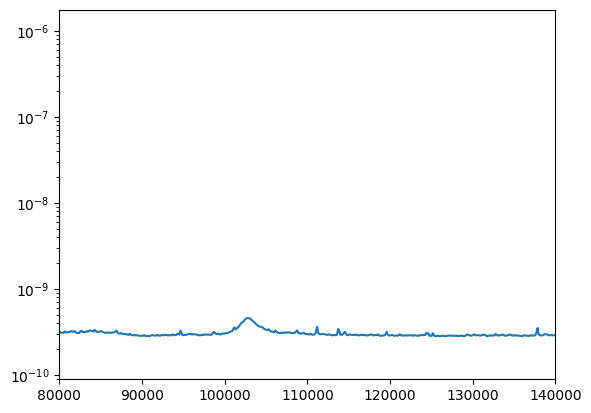

In [96]:
plt.plot(freq_y, unumpy.nominal_values(power_y))
plt.yscale('log')
plt.xlim([80e3,140e3])
plt.show()

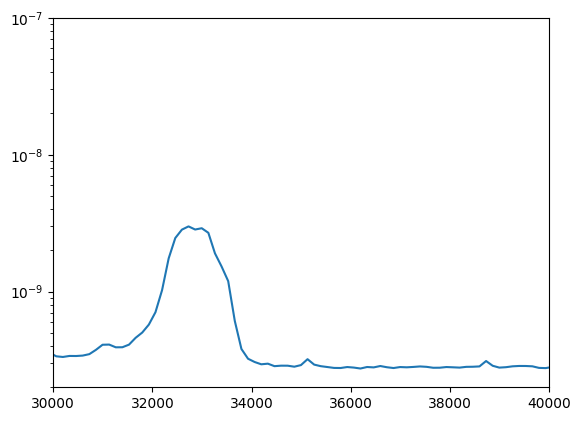

In [102]:
plt.plot(freq_z-5e3, unumpy.nominal_values(power_z))
plt.yscale('log')
plt.xlim([30e3,40e3])
plt.ylim([2e-10, 1e-7])
plt.show()

In [148]:
np.save('freq_x_high_p.npy', freq_x)
np.save('power_x_high_p.npy', unumpy.nominal_values(power_x))
np.save('freq_y_high_p.npy', freq_y)
np.save('power_y_high_p.npy', unumpy.nominal_values(power_y))
np.save('freq_z_high_p.npy', freq_z)
np.save('power_z_high_p.npy', unumpy.nominal_values(power_z))

(90000.0, 100000.0)

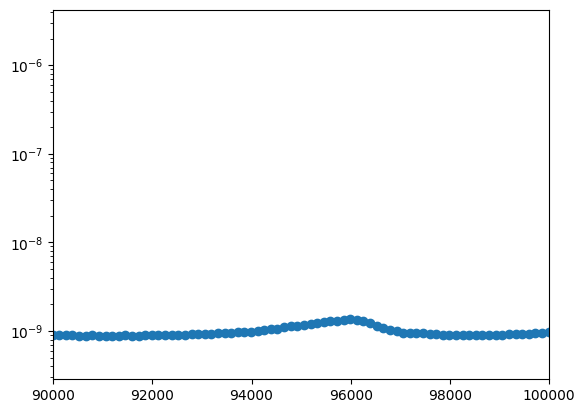

In [161]:
plt.scatter(np.load("freq_x_low_p.npy"), np.load("power_x_low_p.npy"))
#plt.plot(np.load("freq_x_medium_p.npy"), np.load("power_x_medium_p.npy"))
#plt.plot(np.load("freq_x_high_p.npy"), np.load("power_x_high_p.npy"))
plt.yscale('log')
plt.xlim([90e3,100e3])
#plt.ylim([1.5e-9, 1e-6])

(3e-10, 1e-06)

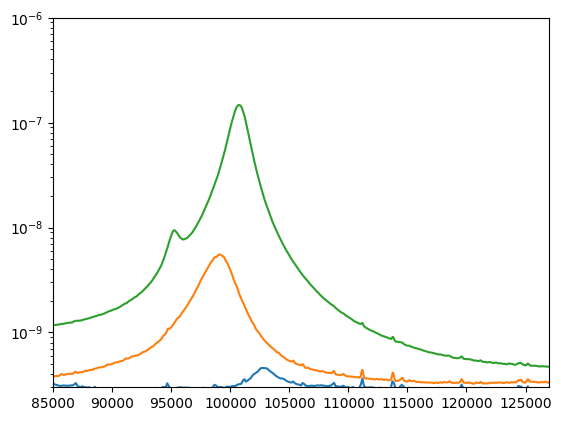

In [112]:
plt.plot(np.load("freq_y_low_p.npy"), np.load("power_y_low_p.npy"))
plt.plot(np.load("freq_y_medium_p.npy"), np.load("power_y_medium_p.npy"))
plt.plot(np.load("freq_y_high_p.npy"), np.load("power_y_high_p.npy"))
plt.yscale('log')
plt.xlim([85e3, 127e3])
plt.ylim([3e-10, 1e-6])

(2e-10, 1e-07)

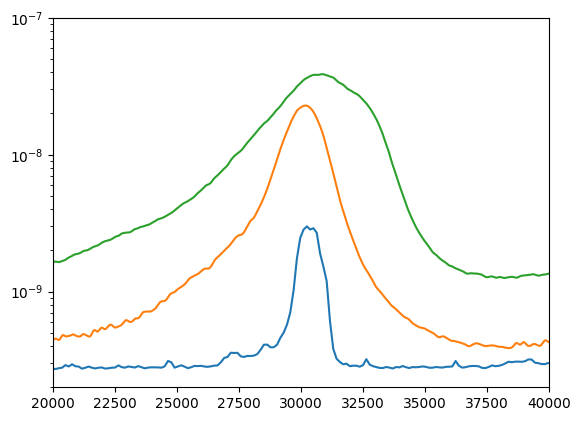

In [109]:
plt.plot(np.load("freq_z_low_p.npy")-7.5e3, np.load("power_z_low_p.npy"))
plt.plot(np.load("freq_z_middle_p.npy"), np.load("power_z_middle_p.npy"))
plt.plot(np.load("freq_z_high_p.npy"), np.load("power_z_high_p.npy"))
plt.yscale('log')
plt.xlim([20e3, 40e3])
plt.ylim([2e-10, 1e-7])